In [1]:
import sys
import os

pwd = os.getcwd()
python_path = pwd[: pwd.rfind("/")]
sys.path.append(python_path)

In [2]:
import torch
import lightning as pl
import jupyter_black
import segmentation_models_pytorch as smp
from data import FakeBacteriasDataModule
from models import BacteriasBinarySegmentation
from utils import show_images
from lightning.pytorch.loggers import TensorBoardLogger

jupyter_black.load()
torch.set_float32_matmul_precision("high")

Image shape: torch.Size([1, 64, 64])


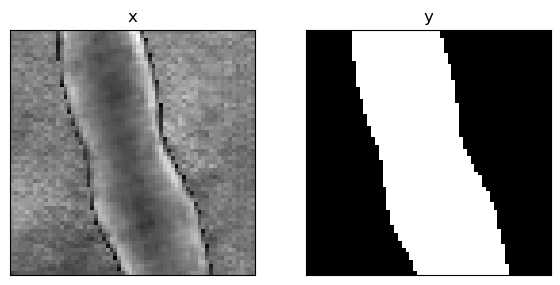

In [3]:
datamodule = FakeBacteriasDataModule(
    batch_size=1, num_workers=0, shuffle=True, train_size=0.9, val_size=0.1, limit=3000
)
datamodule.setup("fit")
loader = datamodule.train_dataloader()
for i, batch in enumerate(loader):
    x, y = batch
    print(f"Image shape: {x[0].shape}")
    show_images(
        [
            (x[0].detach().numpy().squeeze(), "x"),
            (y[0].detach().numpy().squeeze(), "y"),
        ],
        size_inches=(7, 7),
    )
    break

In [12]:
class FPN(pl.LightningModule):
    def __init__(self, lr: float = 0.01):
        super().__init__()
        self.save_hyperparameters()
        self.model = smp.create_model(
            "FPN",
            "resnet34",
            in_channels=1,
            classes=1,
        )
        self.step_outputs = []

    def configure_optimizers(self):
        lr: float = self.hparams.lr  # type: ignore
        return torch.optim.Adam(self.parameters(), lr=lr, betas=(0.5, 0.99))

    def loss(self, y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:
        loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        return loss_fn(y, y_hat)

    def forward(self, x: torch.Tensor):
        y_hat = self.model(x)
        y_hat = y_hat.sigmoid()
        return y_hat

    def shared_step(self, batch: tuple, stage: str):
        x, y = batch

        y_hat = self.forward(x)
        loss = self.loss(y, y_hat)

        pred_mask = (y_hat > 0.5).float()
        stats = smp.metrics.get_stats(pred_mask.long(), y.long(), mode="binary")
        self.step_outputs.append(stats)

        self.log_dict({"loss": loss}, prog_bar=True)
        return loss

    def shared_epoch_end(self, stage: str):
        stats_count = len((self.step_outputs[0]))
        get_stat = lambda i: torch.cat([output[i] for output in self.step_outputs])
        stats = [get_stat(i) for i in range(stats_count)]

        per_image_iou = smp.metrics.iou_score(*stats, reduction="micro-imagewise")
        dataset_iou = smp.metrics.iou_score(*stats, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=False)
        if stage != "valid":
            self.step_outputs.clear()

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def on_train_epoch_end(self):
        return self.shared_epoch_end("train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def on_validation_epoch_end(self):
        return self.shared_epoch_end("valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")

    def on_test_epoch_end(self):
        return self.shared_epoch_end("test")

In [ ]:
BATCH_SIZE = 128
NUM_WORKERS = 1
SHUFFLE = False
TRAIN_SIZE, VAL_SIZE = 0.9, 0.1
LIMIT = 3000
LR = 0.001
EPOCHS = 20

fpn = FPN(lr=LR)
logger = (TensorBoardLogger(save_dir="../../logs/fpn"),)
datamodule = FakeBacteriasDataModule(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=SHUFFLE,
    train_size=TRAIN_SIZE,
    val_size=VAL_SIZE,
    limit=LIMIT,
)

trainer = pl.Trainer(
    max_epochs=EPOCHS, accelerator="gpu", devices=1, logger=logger, log_every_n_steps=10
)
_ = trainer.fit(model=fpn, datamodule=datamodule)

In [6]:
_ = trainer.test(fpn, datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           loss            │    0.35261428356170654    │
└───────────────────────────┴───────────────────────────┘

torch.Size([128, 1, 64, 64])


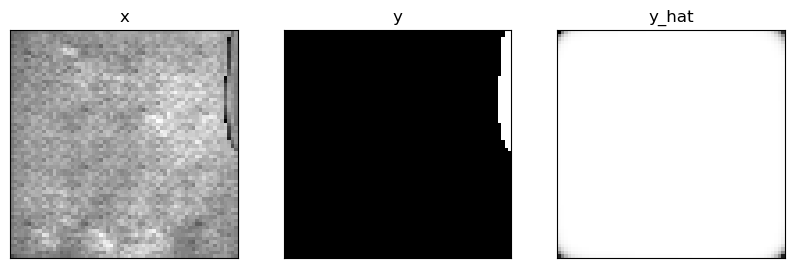

In [16]:
batch = next(iter(datamodule.val_dataloader()))
with torch.no_grad():
    fpn.eval()
    x, y = batch
    y_hat = fpn(x)
show_images(
    [
        (x.detach()[0].numpy().squeeze(), "x"),
        (y.detach()[0].numpy().squeeze(), "y"),
        (y_hat.detach()[0].numpy().squeeze(), "y_hat"),
    ],
    grid=(1, 3),
)